In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from scipy.interpolate import interp1d, interp2d

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sea

from astropy.cosmology import Planck13 as cosmo
from astropy import units as u
from astropy.io import fits
from astropy.table import Table

from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_exam import Gen_spec

import fsps
from grizli import multifit
from grizli import model
from grizli.utils import SpectrumTemplate


import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [309]:
def Gen_initial_MB(field, gid):
    # get beam list
    fl = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/BEAMS/*{}*/*{}*'.format(field,gid))
    
    # sort beams
    sz = []
    for f in fl:
        sz.append(os.path.getsize(f))

    fl = np.array(fl)[np.argsort(sz)]

    # remove repeats
    nlist = []
    blist = []
    for f in fl:
        mb = multifit.MultiBeam(f,**args)
        for bm in mb.beams:
            if bm.grism.parent_file not in nlist:
                nlist.append(bm.grism.parent_file)
                blist.append(bm)
    
    #make the mb
    mb = multifit.MultiBeam(blist,**args)

    for b in mb.beams:
        if hasattr(b, 'xp'):
            delattr(b, 'xp')
    mb.initialize_masked_arrays()
    
    return mb

def Plot_grism(MB,ax, color,instr, lims):
    sptbl = MB.oned_spectrum()

    w = sptbl[instr]['wave']
    f = sptbl[instr]['flux']
    e = sptbl[instr]['err']
    fl = sptbl[instr]['flat']
        
    clip = [U for U in range(len(w)) if lims[0] < w[U] < lims[1]]

    ax.errorbar(w[clip],f[clip]/fl[clip],e[clip]/fl[clip], color = color,
                linestyle='None', marker='o', markersize=0.25, zorder = 1, elinewidth = 1)

def Plot_beams(mb,W,P,E):
    gs = gridspec.GridSpec(2,2)

    plt.figure(figsize=[20,12])
    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,1])

    for bm in mb.beams:
        xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)

        flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
        xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)

        if bm.grism.filter == 'G102':
            IDX = [U for U in range(len(xspec)) if 8000 < xspec[U] < 11300]
            ax1.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'b')
        else:
            IDX = [U for U in range(len(xspec)) if 11200 < xspec[U] < 16500]
            ax2.plot(xspec[IDX],yspec[IDX]/yspecm[IDX], color = 'r') 
    
    ax = plt.subplot(gs[1,:])
    try:
        Plot_grism(mb , ax, 'b', 'G102', [8000,11500])
    except:
        pass
    try:
        Plot_grism(mb , ax, 'r', 'G141', [11000,16500])
    except:
        pass
    
    IDP = [U for U in range(len(W)) if P[U]/E[U]  > 0.01]

    
    ax.errorbar(np.array(W)[IDP],np.array(P)[IDP],np.array(E)[IDP], fmt='o', color='k', zorder=0)
    ax.set_xscale('log')    
    
def Beam_cleanup(mb, B_condition=[], R_condition=[]):
    ## conditions in form of [low-wv, hi-wv, gtr or less, flux, clip or omit]
    Bselect = False
    Rselect = False
    
    if len(B_condition) == 5:
        Bwvl, Bwvh, B_cond, Bfl, B_cl = B_condition
        Bselect = True

    if len(R_condition) == 5:
        Rwvl, Rwvh, R_cond, Rfl, R_cl = R_condition
        Rselect = True

    BEAM_exempt =[]
    ids = 0
    cleanspec = []
    clip_lims = []
    ### selection for bad beams
    for bm in mb.beams:
        xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar)
        flat_model = bm.flat_flam.reshape(bm.beam.sh_beam)
        xspecm, yspecm, yerrm = bm.beam.optimal_extract(flat_model)
        bex = False

        if Bselect:
            for i in range(len(xspec)):
                if B_cond == 'gtr':
                    if (bm.grism.filter == 'G102' and Bwvl < xspec[i] < Bwvh) and (yspec[i]/yspecm[i]) > Bfl:
                        bex = True
                        cleanspec.append(B_cl)
                        clip_lims.append([Bwvl, Bwvh])
                        break

                if B_cond == 'less':
                    if (bm.grism.filter == 'G102' and Bwvl < xspec[i] < Bwvh) and (yspec[i]/yspecm[i]) < Bfl:
                        bex = True
                        cleanspec.append(B_cl)
                        clip_lims.append([Bwvl, Bwvh])
                        break
        
        if Rselect:
            for i in range(len(xspec)):
                if R_cond == 'gtr':
                    if (bm.grism.filter == 'G141' and Rwvl < xspec[i] < Rwvh) and (yspec[i]/yspecm[i]) > Rfl:
                        bex = True
                        cleanspec.append(R_cl)
                        clip_lims.append([Rwvl, Rwvh])
                        break

                if R_cond == 'less':
                    if (bm.grism.filter == 'G141' and Rwvl < xspec[i] < Rwvh) and (yspec[i]/yspecm[i]) < Rfl:
                        bex = True
                        cleanspec.append(R_cl)
                        clip_lims.append([Rwvl, Rwvh])
                        break

        if bex:
            BEAM_exempt.append(bm.grism.parent_file)

    ### set up selection settings
    
    omitspec = np.zeros(len(BEAM_exempt))
    clipspec = np.zeros(len(BEAM_exempt))
    for i in range(len(cleanspec)):
        if cleanspec[i] == 'clip':
            clipspec[i] = 1
            
        if cleanspec[i] == 'omit':
            omitspec[i] = 1   
    return BEAM_exempt, clip_lims, clipspec, omitspec
            
def Clean_mb(mb, BEAM_exempt, clip_lims, clipspec, omitspec):   
    fblist = []
    idc = 0
    for bm in mb.beams:
        if bm.grism.parent_file in BEAM_exempt:            
            if clipspec[idc] == 1:
                xspec, yspec, yerr = bm.beam.optimal_extract(bm.grism.data['SCI'] - bm.contam,ivar = bm.ivar) 
                lms = clip_lims[idc]
                for i in range(len(xspec)):
                    if lms[0] < xspec[i]< lms[1]:
                        bm.grism.data['SCI'].T[i] = np.zeros_like(bm.grism.data['SCI'].T[i])
                        bm.grism.data['ERR'].T[i] = np.ones_like(bm.grism.data['ERR'].T[i])*1000  

            if omitspec[idc] == 1:
                pass
            else:    
                fblist.append(bm)

            idc += 1

        else:    
            fblist.append(bm)   

    mb = multifit.MultiBeam(fblist,**args)
    for b in mb.beams:
        if hasattr(b, 'xp'):
            delattr(b, 'xp')
    mb.initialize_masked_arrays()
    
    return mb

def Phot_load(field, galaxy_id,ref_cat_loc,masterlist = '../phot/master_template_list.pkl'):
    galdf = ref_cat_loc[ref_cat_loc.id == galaxy_id]
    master_tmp_df = pd.read_pickle(masterlist)

    if field == 'GSD':
        pre= 'S_'

    if field == 'GND':
        pre= 'N_'

    eff_wv = []
    phot_fl = []
    phot_er = []
    phot_num = []

    for i in galdf.keys():
        if i[0:2] == 'f_':
            Clam = 3E18 / master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0] **2 * 10**((-1.1)/2.5-29)
            if galdf[i].values[0] > -99.0:
                eff_wv.append(master_tmp_df.eff_wv[master_tmp_df.tmp_name == pre + i].values[0])
                phot_fl.append(galdf[i].values[0]*Clam)
                phot_num.append(master_tmp_df.tmp_num[master_tmp_df.tmp_name == pre + i].values[0])
        if i[0:2] == 'e_':
            if galdf[i].values[0] > -99.0:
                phot_er.append(galdf[i].values[0]*Clam)
    
    return eff_wv, phot_fl, phot_er

In [52]:
GND_all = pd.read_pickle('../dataframes/galaxy_frames/GND_CLEAR.pkl')
GSD_all = pd.read_pickle('../dataframes/galaxy_frames/GSD_CLEAR.pkl')

v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

In [13]:
temps = {}
for k in args['t1']:
    if k[0] == 'f' or k[5:] in ['Ha', 'Hb', 'Hg', 'Hd'] :
        temps[k] = args['t1'][k]

In [306]:
idx

92

In [304]:
db = GND_all
field = 'N'
cat = v4Ncat

idx = db.index[81]
rshift = db.zphot[idx] 

if len(str(db.id[idx])) < 5:
    gid = '0' + str(db.id[idx])
else:
    gid = str(db.id[idx])

W,P,E = Phot_load('G{}D'.format(field), db.id[idx], cat)

mb  = Gen_initial_MB(field, gid)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.

1 icat25hcq_flt.fits G102
2 icat25hiq_flt.fits G102
3 icat25icq_flt.fits G102
4 icat25iiq_flt.fits G102
5 ib3725dyq_flt.fits G141
6 ib3725e2q_flt.fits G141
7 ib3725eeq_flt.fits G141
8 ib3725eiq_flt.fits G141


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:607: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:608: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)


[]
[] []
[]


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3510: RuntimeWarning: divide by zero encountered in true_divide
  s

N 15998 0.7708716035205906


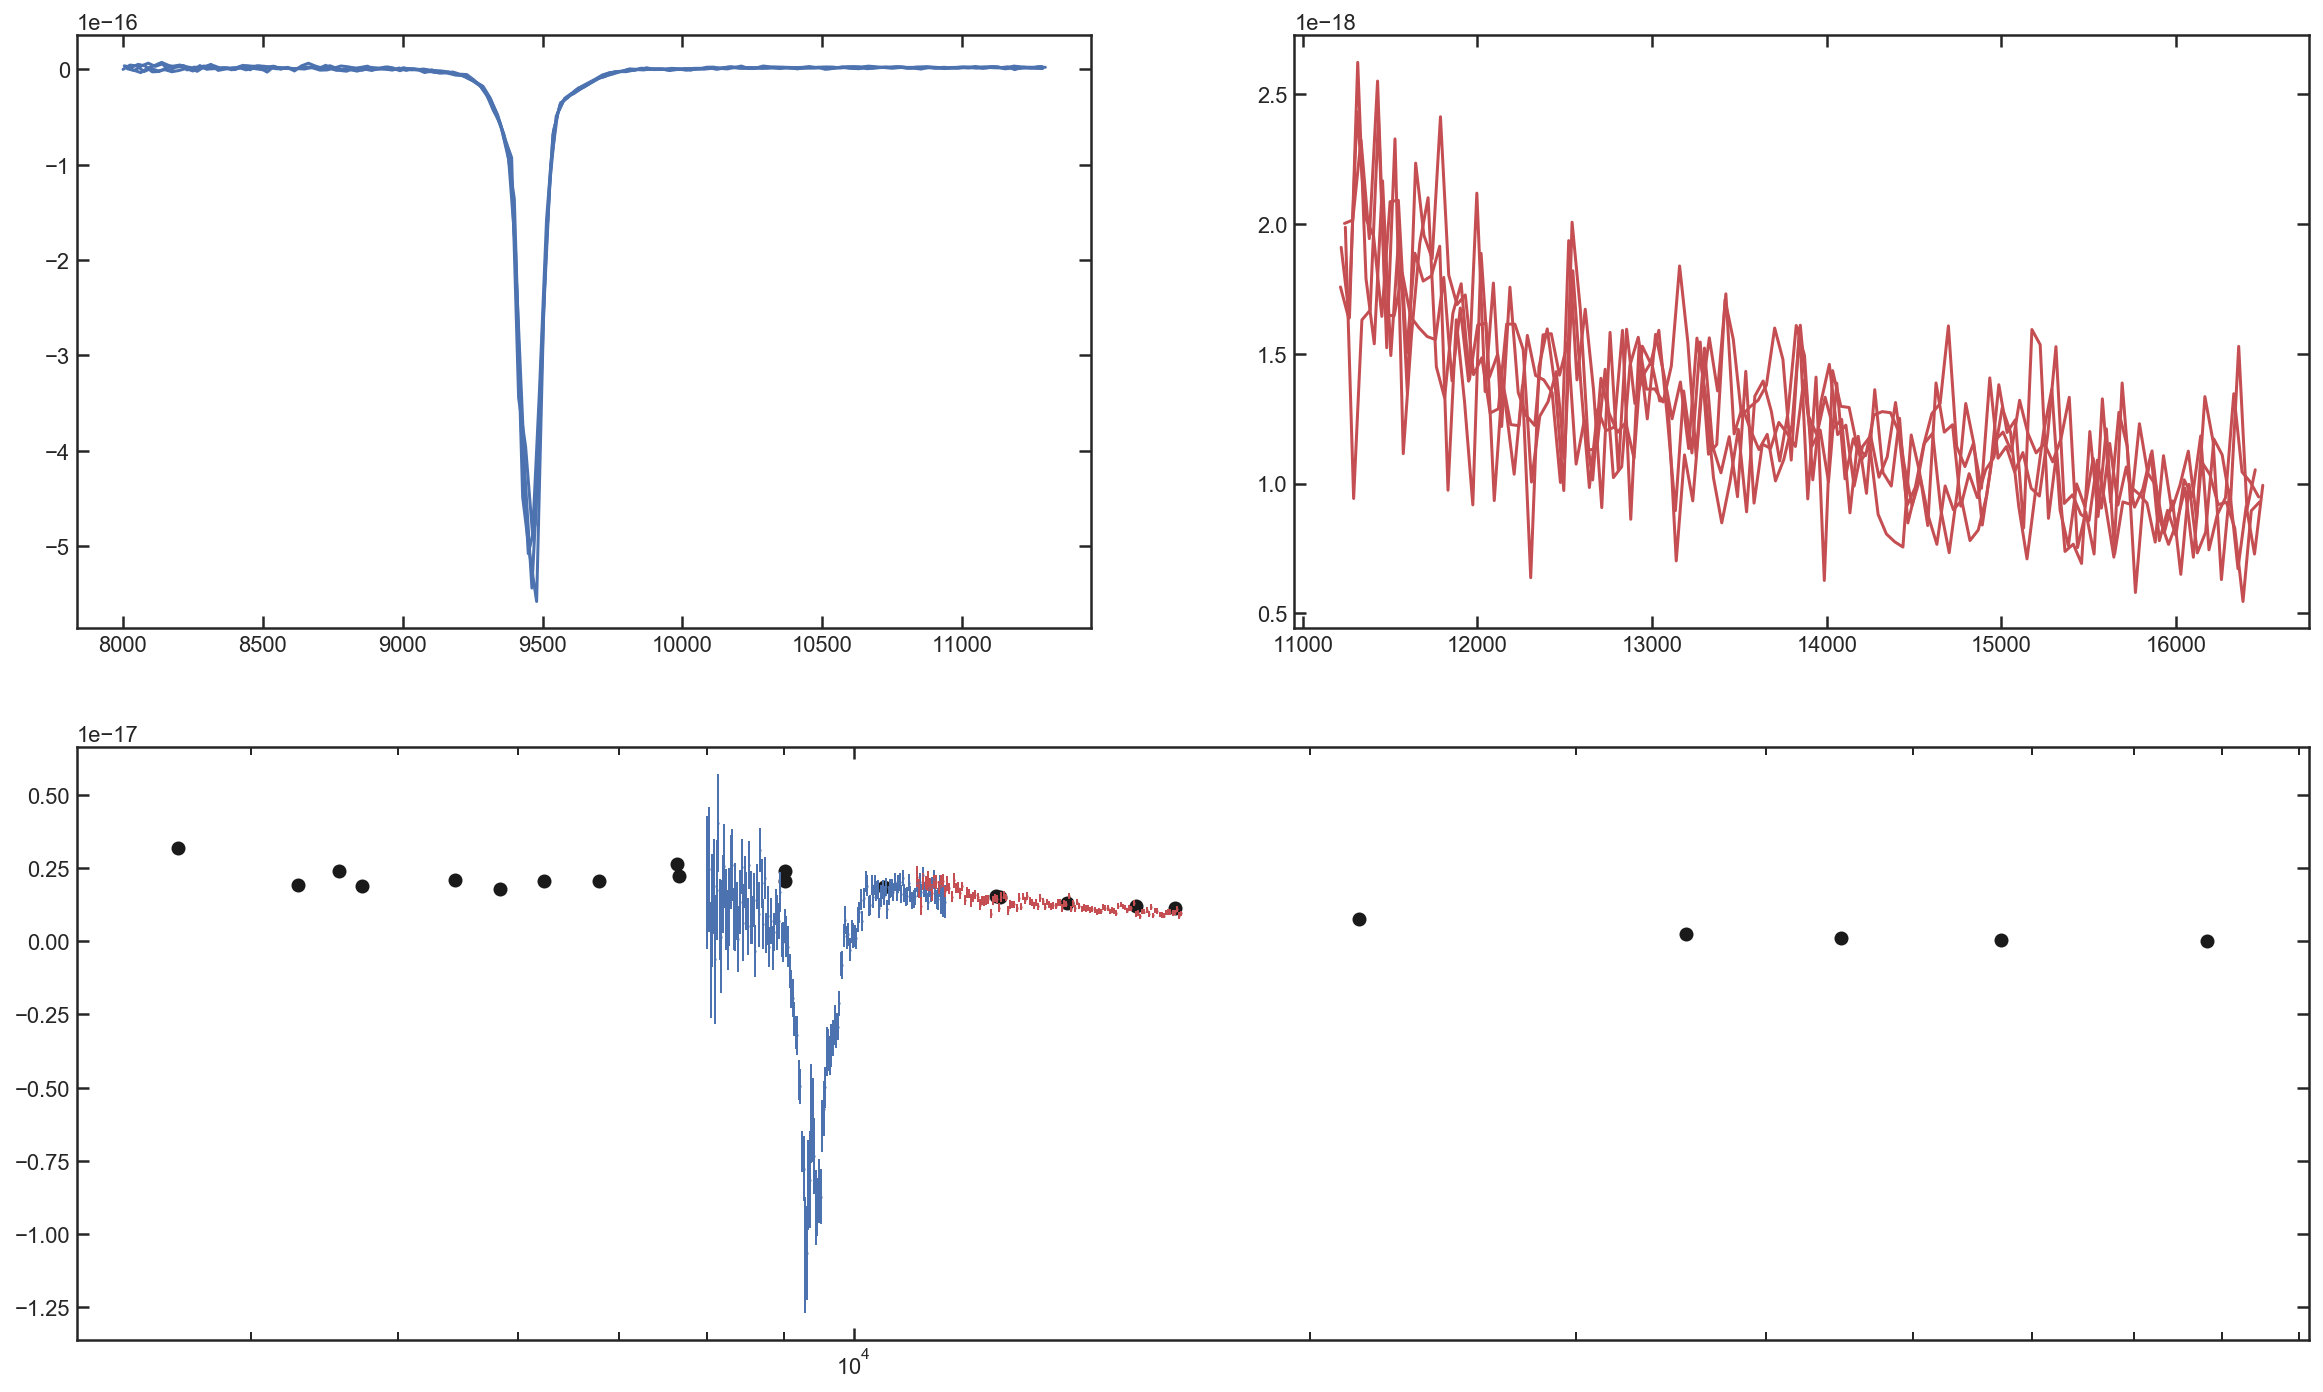

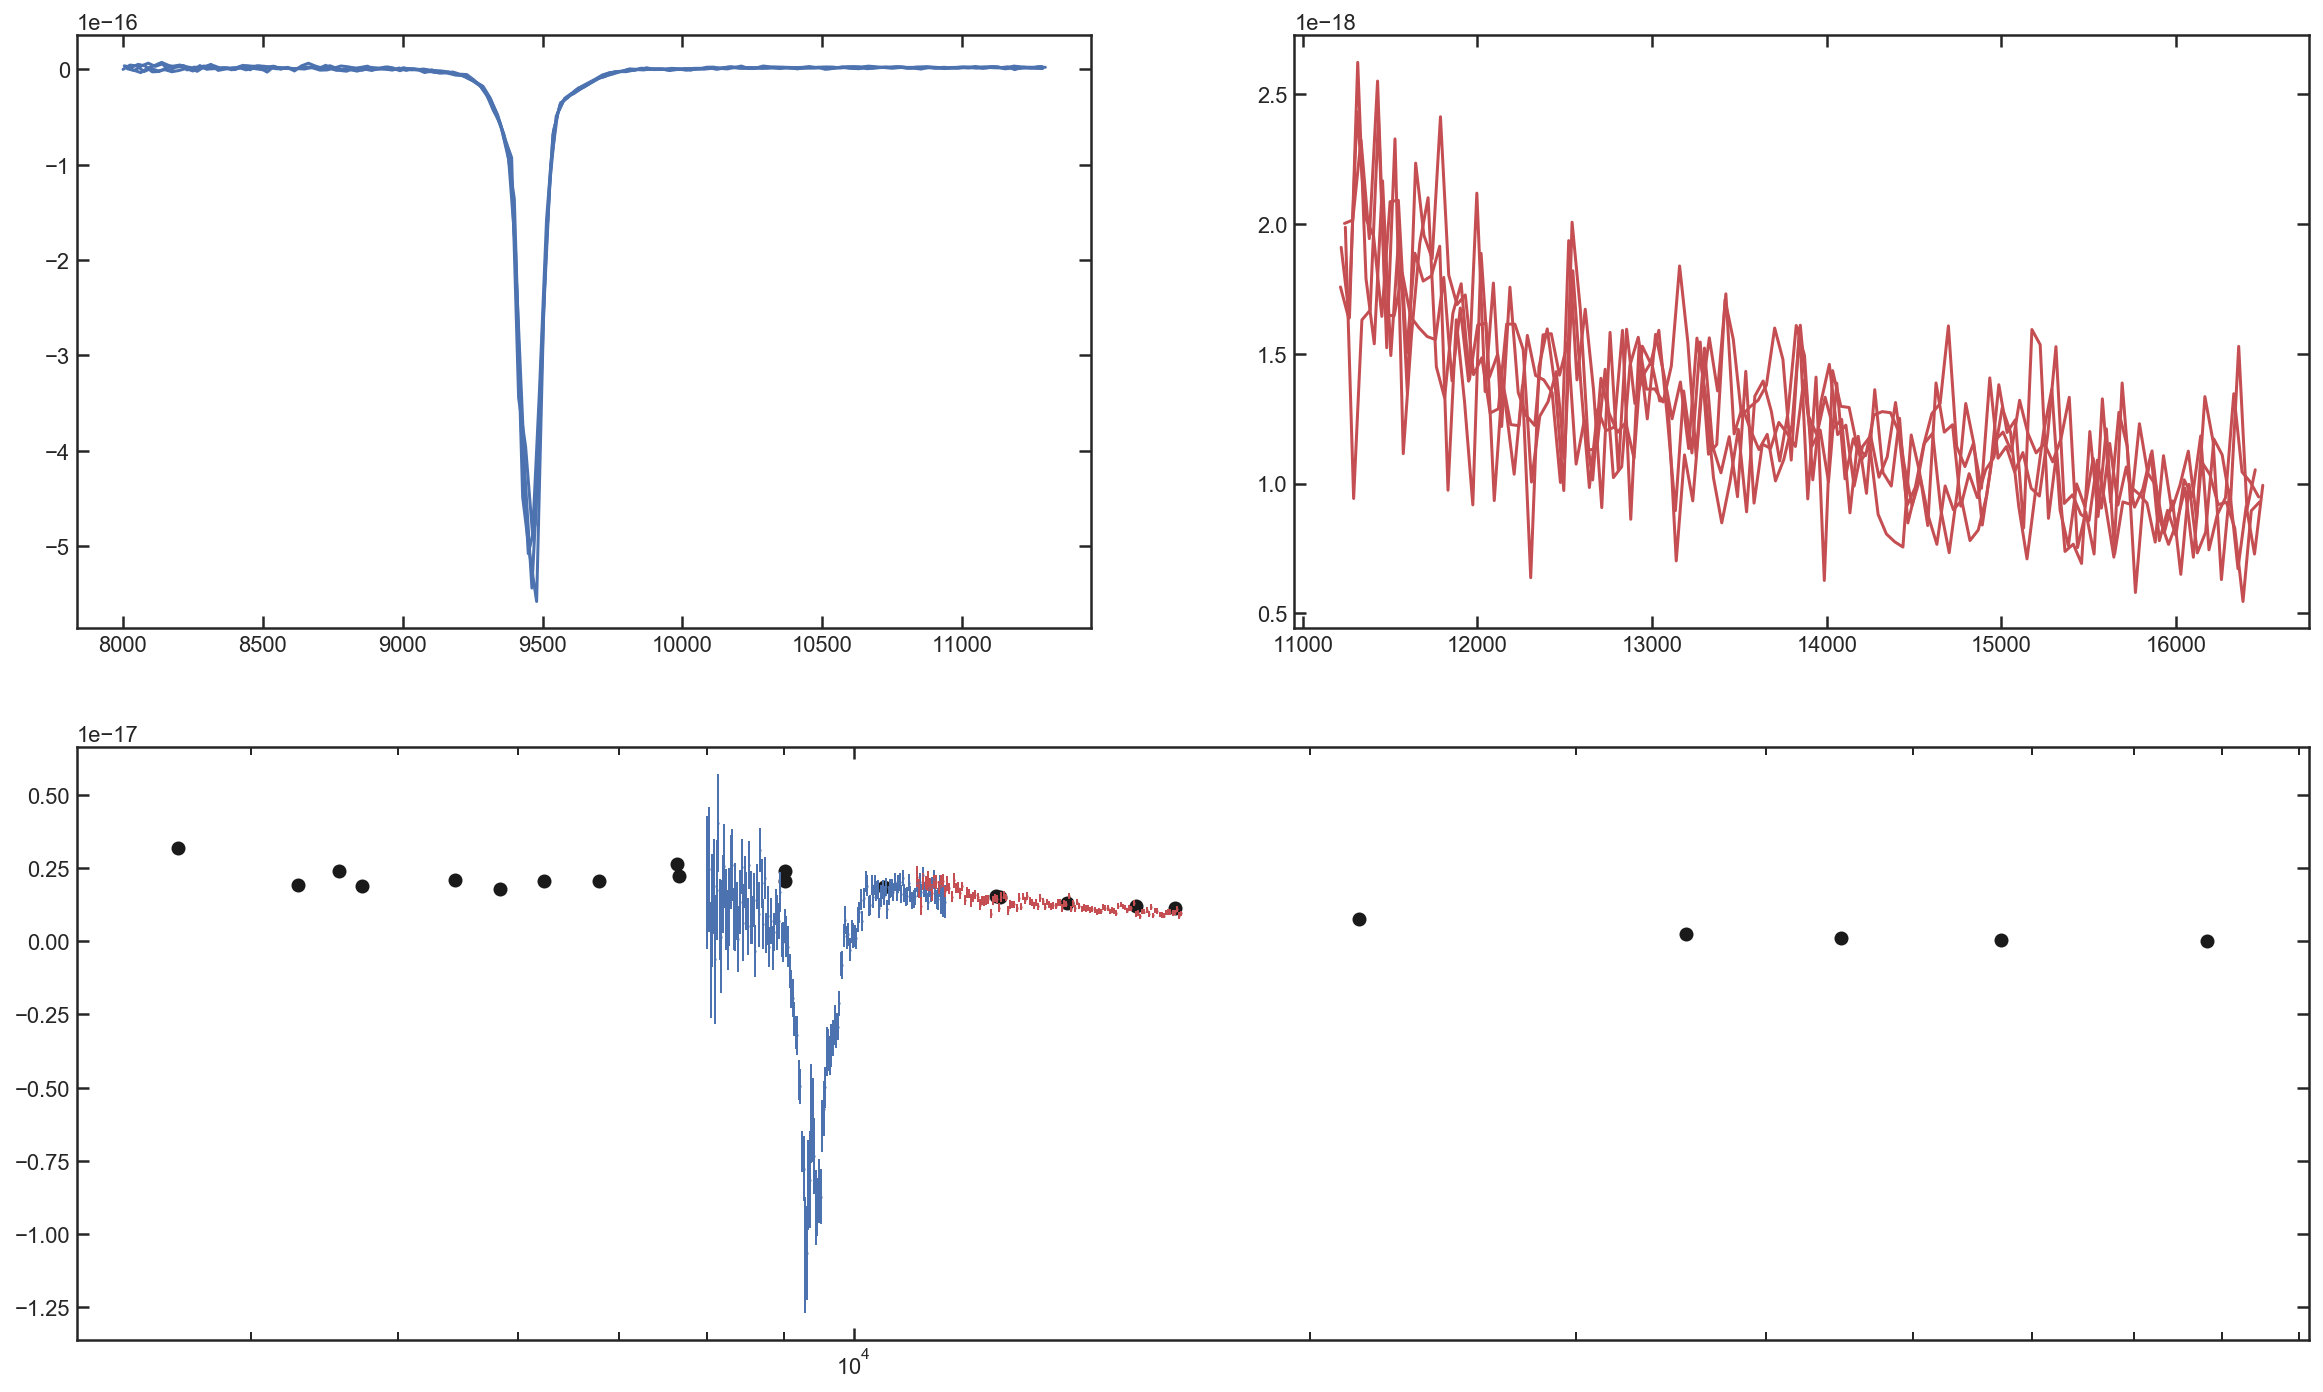

In [310]:
## conditions in form of [low-wv, hi-wv, gtr or less, flux, clip or omit]
#0, 11500, 'less', 0, 'clip'
Plot_beams(mb,W,P,E)
BMX, Clims, Cspec, Ospec = Beam_cleanup(mb, B_condition=[], R_condition=[])
print(BMX)
print(Clims, Cspec)
print(Ospec)

MB = Clean_mb(mb, BMX, np.array(Clims), Cspec, Ospec)
Plot_beams(MB,W,P,E)

np.save('../beams/beam_config/G{}D_{}_ex'.format(field, gid),[BMX])
np.save('../beams/beam_config/G{}D_{}'.format(field, gid),[Clims, Cspec, Ospec])

print(field, gid, rshift)

In [ ]:
    plt.savefig('../plots/allspec_exam/G{}D-{}_beams.png'.format(field, gid),bbox_inches = 'tight')
